Plane regular waves - Nonlinear waves using Fourier series
====================================================

Nonlinear waves typically deviate from the sinusoidal shape when they start "feeling" the presence of the sea bed. Using the MonochromaticWave class, we can set the waveType to "Fenton" to generate nonlinear waves. The method used can be found in Fenton (1988) http://johndfenton.com/Papers/Fenton88-The-numerical-solution-of-steady-water-wave-problems.pdf

Free-surface elevation equation:

$$
\eta(\vec{x},z,t)=\Sigma_1^N a_i \cos i(\vec{k}\cdot\vec{x}-\omega t +\phi) 
$$

Equation of velocity along the wave propagation direction:

$$
U_h(\vec{x},z,t)=\Sigma_1^N u_{h(i)} \cos i(\vec{k}\cdot\vec{x}-\omega t +\phi)\cosh i(k(d+z))
$$

Equation of velocity along the gravity direction:

$$
U_v(\vec{x},z,t)=\Sigma_1^N  u_{v(i)} \sin i(\vec{k}\cdot\vec{x}-\omega t +\phi)\sinh i(k(d+z))
$$

Fourier series coefficients $a_i$, $u_{h(i)}$ and $u_{h(i)}$ are calculated using the tool available in http://johndfenton.com/Steady-waves/Fourier.zip. This tool also be used to calculate the solution of a wave(linear and nonliner) interacting with a current. 




`MonochromaticWaves` Class for nonlinear waves 
======================================================

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import sys


To load WaveTools from proteus source files, without compiling:


In [2]:
sys.path.append("C:/Users/present/Desktop/proteus/")
#The notebook will work with the following commit:
#https://github.com/erdc-cm/proteus/commit/9bb34b3563b5ddab6cb1dd9f75173da2710d2a41
from proteus import Profiling,SpatialTools
#import imp
#WT = imp.load_source('WaveTools', 'WaveTools.pyx')


To load WaveTools if proteus is installed


In [3]:
from proteus import WaveTools as WT

Setting up wave parameters and calling the class
=========================================

A brief description of the arguments is given in the source code. WaveTools does some basic checks and logs error messages if inconsistencies are found among the parameters

In [4]:
waveType ="Fenton" 
period = 12.
waveHeight = 1.
mwl = 0.
depth = 5.
g = np.array([0., 0., -9.81])
waveDir = np.array([2., 2., 0.])
norm = WT.setDirVector(waveDir)
normVert = WT.setVertDir(g)
meanVelocity = np.array([0., 0., 0.])
phi0 = 0.


Apart from the typical wave parameters, in this case we have to define the wavelenght (linear dispersion may not be accurate) and the Fourier series coefficient. To do this, we need to run this tool http://johndfenton.com/Steady-waves/Fourier.zip. Instructions on the tools output are given in http://johndfenton.com/Steady-waves/Instructions.pdf


In [5]:
Fenton_kH = 0.0741
Ycoeff = np.array([3.13E-02,1.39E-02,5.05E-03,1.73E-03,5.88E-04,2.05E-04,8.01E-05,5.09E-05])
Bcoeff = np.array([5.18E-02,1.17E-02,2.80E-03,6.56E-04,1.43E-04,2.74E-05,3.98E-06,2.63E-07])
ki =Fenton_kH /waveHeight
wavelength = 2*np.pi/ki

In [6]:
#Calling the class
FW = WT.MonochromaticWaves(period,
                        waveHeight,
                        mwl,
                        depth,
                        g,
                        waveDir,
                        wavelength,
                        waveType,
                        Ycoeff,
                        Bcoeff,
                        meanVelocity,
                        phi0
                        )

We use class functions `eta` and `u` for calculating free-surface elevation (as a scalar) and velocity (as a vector).  

Calculating and plotting waves
=============================================================

Setting up the 3D domain

In [7]:
#Setting up the plan view area and the depth domain
n=151
xi = np.linspace(0, 200, n)
yi = np.linspace(0, 200, n)
zi = np.linspace(mwl-depth, mwl+waveHeight, n)

We can calculate a time series of the free-surface elevation using the `eta`  function and looping over time for a fixed point in space

In [8]:
psize = 20
#Setting up a time interval of n periods (using npoints sampling points per period)
nperiod = 4
npoints = 40
nn = npoints * nperiod
tnlist=np.linspace(0,nperiod*period,nn)
eta_t = np.zeros(len(tnlist),)
x = [2,1,1]
#Calculating time series
for i in range(len(tnlist)):
    t = tnlist[i]
    eta_t[i] = FW.eta(x, t)

Plotting the timeseries

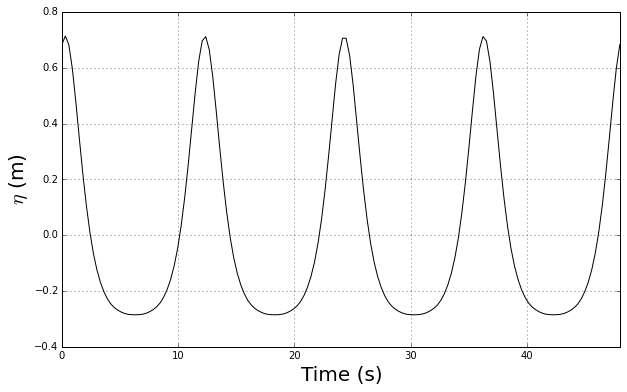

In [9]:
#Plotting time series
plt.figure(2, figsize=(10,6), dpi=100)
plt.xlim(0., nperiod*period)
plt.plot(tnlist, eta_t, "k-")
plt.xlabel("Time (s)", size=psize)
plt.ylabel("$\eta$ (m)", size=psize)
plt.grid()
plt.show()

We can also plot the free-surface at the x-y plane (wave propagation plane) using a contour plot

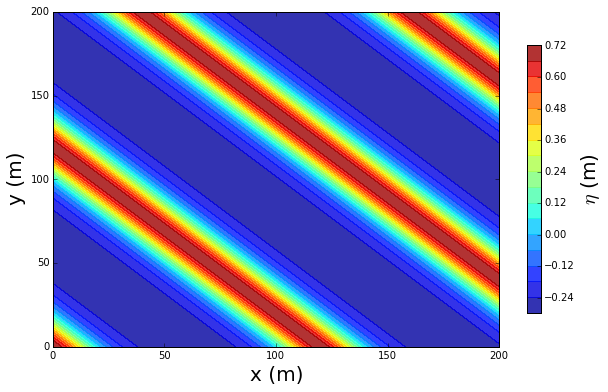

In [10]:
eta_t = np.zeros((n, n),)
for i in range(len(xi)):
    for j in range(len(yi)):
        x = [xi[i], yi[j], 0]
        eta_t[i,j] = FW.eta(x, 0.)

        
#Plotting the contour        
plt.figure(1, figsize=(10, 6), dpi=100)
X,Y = np.meshgrid(xi,yi)
CS = plt.contourf(Y,X,eta_t, 16, alpha=0.8)
plt.xlabel("x (m)", size=psize)
plt.ylabel("y (m)", size=psize)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label("$\eta$ (m)", size = psize)
plt.show()


In the next cell we plot contours, showing horizontal and vertical velocity profiles at a vertical plane, aligned with the wave propagation direction 


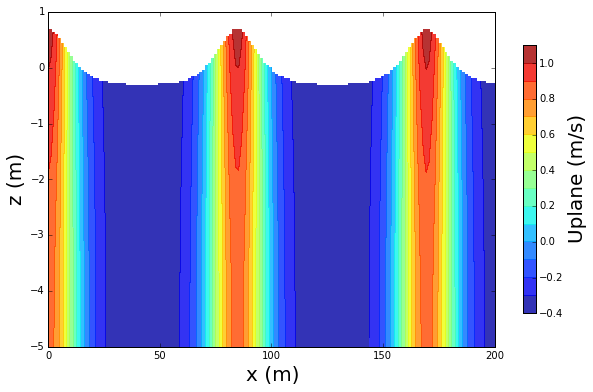

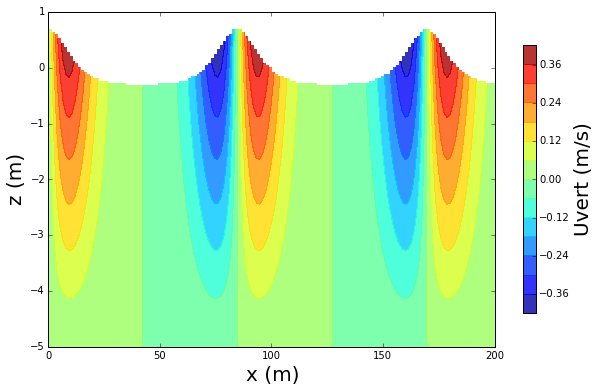

In [11]:
#Calculating velocity contours
ur  = np.zeros((len(xi),len(zi)),)
uv  = np.zeros((len(xi),len(zi)),)
for i in range(len(xi)):
    for ii in range(len(zi)):
        x = xi[i]*norm + [0,0,zi[ii]]
        ur[i,ii] = sum(FW.u(x, 0.)[:]*norm[:])
        uv[i,ii] = sum(FW.u(x, 0.)[:]*normVert[:])  
        if zi[ii]>  FW.eta(x,0.):
            ur[i,ii] = np.nan
            uv[i,ii] = np.nan
    
#Plotting velocity contours
plt.figure(3,figsize=(10, 6), dpi=100)
X,Y = np.meshgrid(zi,yi)
CS = plt.contourf(Y,X,ur, 16, alpha=0.8, cmap='jet')
plt.xlabel("x (m)", size=psize)
plt.ylabel("z (m)", size=psize)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label("Uplane (m/s)", size = psize)
plt.show()

plt.figure(4,figsize=(10, 6), dpi=100)
X,Y = np.meshgrid(zi,yi)
CS = plt.contourf(Y,X,uv, 16, alpha=0.8, cmap='jet')
plt.xlabel("x (m)", size=psize)
plt.ylabel("z (m)", size=psize)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
CB.set_label("Uvert (m/s)", size = psize)
plt.show()


In the cell below, we load the class another two times, introducing following and opposing currents. We plot the free surface profile in space in order to demonstrate the doppler effect


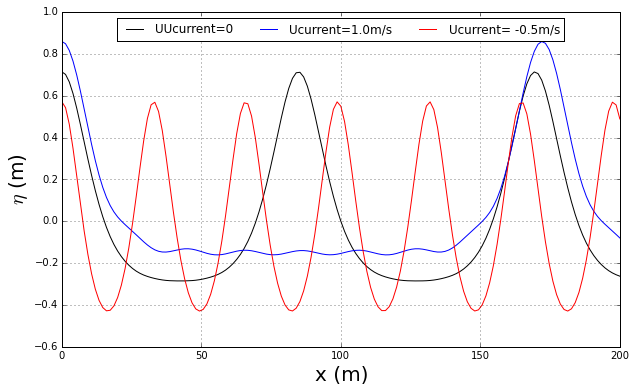

In [12]:
meanVelocity = norm

Fenton_kH = 0.0365
Ycoeff = np.array([9.95E-03,7.65E-03,5.24E-03,3.35E-03,2.10E-03,1.34E-03,9.44E-04,7.85E-04])
Bcoeff = np.array([2.29E-02,8.85E-03,4.07E-03,1.95E-03,9.64E-04,4.97E-04,2.84E-04,1.00E-04])

ki =Fenton_kH /waveHeight
wavelength = 2*np.pi/ki


FWfoll = WT.MonochromaticWaves(period,
                        waveHeight,
                        mwl,
                        depth,
                        g,
                        waveDir,
                        wavelength,
                        waveType,
                        Ycoeff,
                        Bcoeff,
                        meanVelocity,
                        phi0
                        )
#Following current
#To calculate these coefficients use http://johndfenton.com/Steady-waves/Fourier.html
meanVelocity = -0.5*norm


Fenton_kH = 0.1907
Ycoeff = np.array([9.34E-02,1.32E-02,1.92E-03,3.14E-04,5.66E-05,1.09E-05,2.27E-06,8.97E-07])
Bcoeff = np.array([1.08E-01,6.53E-03,2.18E-04,-8.25E-06,-1.27E-06,-2.22E-09,9.51E-09,5.73E-10])

ki =Fenton_kH /waveHeight
wavelength = 2*np.pi/ki

FWopp = WT.MonochromaticWaves(period,
                        waveHeight,
                        mwl,
                        depth,
                        g,
                        waveDir,
                        wavelength,
                        waveType,
                        Ycoeff,
                        Bcoeff,
                        meanVelocity,
                        phi0
                        )

#Calculating velocity contours
norm = WT.setDirVector(waveDir)
eta_t  = np.zeros((len(xi),3,))
for i in range(len(xi)):
    x = xi[i]*norm
    eta_t[i,0] = FW.eta(x,0.)
    eta_t[i,1] = FWfoll.eta(x,0.)    
    eta_t[i,2] = FWopp.eta(x,0.)      

#Plotting time series
plt.figure(2, figsize=(10,6), dpi=100)
plt.plot( xi, eta_t[:,0], color="black",label="UUcurrent=0")
plt.plot( xi, eta_t[:,1], color="blue",label="Ucurrent=1.0m/s")
plt.plot( xi, eta_t[:,2], color="red",label="Ucurrent= -0.5m/s")
plt.legend(loc="upper center",ncol=3)
plt.xlabel("x (m)", size=psize)
plt.ylabel("$\eta$ (m)", size=psize)
plt.grid()
plt.show()